Loading dataset...
Loaded 1596 samples, 96 features each.

Best PCA variance = 91%

Validation Accuracy for each k:
k=1 -> Validation Accuracy: 93.71%
k=3 -> Validation Accuracy: 67.92%
k=5 -> Validation Accuracy: 53.46%
k=7 -> Validation Accuracy: 52.20%
k=9 -> Validation Accuracy: 49.06%
k=11 -> Validation Accuracy: 50.31%
k=13 -> Validation Accuracy: 44.03%
k=15 -> Validation Accuracy: 46.54%
k=17 -> Validation Accuracy: 49.06%
k=19 -> Validation Accuracy: 46.54%
k=21 -> Validation Accuracy: 45.91%
k=23 -> Validation Accuracy: 45.91%
k=25 -> Validation Accuracy: 45.91%
k=27 -> Validation Accuracy: 45.28%
k=29 -> Validation Accuracy: 41.51%
k=31 -> Validation Accuracy: 42.77%
k=33 -> Validation Accuracy: 42.77%

Best k (from validation) = 1, Validation Accuracy = 93.71%
Test Accuracy: 93.75%


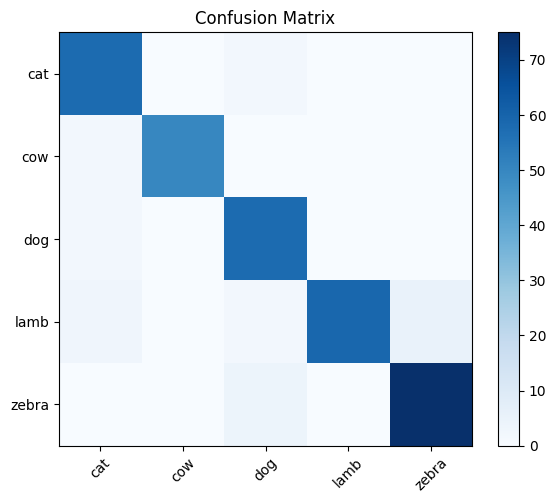

Class        Precision  Recall  F1-Score  Support
----------------------------------------------
cat              89.23   96.67     92.80       60
cow             100.00   96.15     98.04       52
dog              87.88   96.67     92.06       60
lamb            100.00   85.51     92.19       69
zebra            93.75   94.94     94.34       79
----------------------------------------------
Avg/Total        94.17   93.99     93.89      320


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # optional, for future data handling if needed

# ================= CONFIG =================
DATASET_DIR = "/kaggle/input/animal-images/dataset"
CATEGORIES = ["cat", "cow", "dog", "lamb", "zebra"]
IMG_SIZE = (64, 64)
BINS = 32
AUGMENT = True
SEED = 42
# =========================================

np.random.seed(SEED)

# ================= IMAGE FUNCTIONS =================
def load_and_resize_image(path, size=IMG_SIZE):
    img = plt.imread(path)
    if img.dtype in [np.float32, np.float64]:
        img = (img * 255).astype(np.uint8)
    old_h, old_w = img.shape[:2]
    row_idx = (np.linspace(0, old_h-1, size[0])).astype(int)
    col_idx = (np.linspace(0, old_w-1, size[1])).astype(int)
    return img[row_idx[:, None], col_idx]

def horizontal_flip(img): return np.fliplr(img)
def rotate_90(img, k=1): return np.rot90(img, k)

def extract_features(img):
    features = []
    for ch in range(3):
        hist, _ = np.histogram(img[:, :, ch], bins=BINS, range=(0,256))
        hist = hist / (np.sum(hist)+1e-8)
        features.extend(hist)
    return np.array(features)

def standardize_features(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    return (X - mean) / std

def apply_pca(X, explained_variance=0.95):
    mean = X.mean(axis=0)
    X_centered = X - mean
    cov = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    total_var = np.cumsum(eigvals)/np.sum(eigvals)
    n_components = np.searchsorted(total_var, explained_variance)+1
    top_vecs = eigvecs[:, :n_components]
    X_reduced = X_centered @ top_vecs
    return X_reduced, mean, top_vecs

def knn_predict(X_train, y_train, X_test, k):
    dists = np.sqrt(((X_test[:, None, :] - X_train[None, :, :])**2).sum(axis=2))
    nearest = np.argsort(dists, axis=1)[:, :k]
    preds = np.array([np.bincount(y_train[n]).argmax() for n in nearest])
    return preds

# ================= METRICS =================
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

def confusion_matrix(y_true, y_pred):
    n = len(CATEGORIES)
    matrix = np.zeros((n, n), dtype=int)
    for t, p in zip(y_true, y_pred):
        matrix[t, p] += 1
    return matrix

def classification_report(y_true, y_pred, class_names):
    report = []
    for i, cls in enumerate(class_names):
        tp = np.sum((y_pred == i) & (y_true == i))
        fp = np.sum((y_pred == i) & (y_true != i))
        fn = np.sum((y_pred != i) & (y_true == i))
        precision = tp / (tp + fp + 1e-12)
        recall = tp / (tp + fn + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        support = np.sum(y_true == i)
        report.append((cls, precision, recall, f1, support))

    print(f"{'Class':<12} {'Precision':>9} {'Recall':>7} {'F1-Score':>9} {'Support':>8}")
    print("-" * 46)
    for cls, prec, rec, f1, sup in report:
        print(f"{cls:<12} {prec*100:9.2f} {rec*100:7.2f} {f1*100:9.2f} {sup:8}")
    print("-" * 46)
    avg_prec = np.mean([r[1] for r in report])
    avg_rec = np.mean([r[2] for r in report])
    avg_f1 = np.mean([r[3] for r in report])
    total_sup = np.sum([r[4] for r in report])
    print(f"{'Avg/Total':<12} {avg_prec*100:9.2f} {avg_rec*100:7.2f} {avg_f1*100:9.2f} {total_sup:8}")

# ================= LOAD DATA =================
def load_images():
    data, labels = [], []
    for idx, cat in enumerate(CATEGORIES):
        folder = os.path.join(DATASET_DIR, cat)
        for file in sorted(os.listdir(folder)):
            try:
                img = load_and_resize_image(os.path.join(folder, file))
                data.append(extract_features(img)); labels.append(idx)
                if AUGMENT:
                    data.append(extract_features(horizontal_flip(img))); labels.append(idx)
                    data.append(extract_features(rotate_90(img,1))); labels.append(idx)
            except: continue
    return np.array(data), np.array(labels)

# ================= MAIN =================
print("Loading dataset...")
X, y = load_images()
print("Loaded", X.shape[0], "samples,", X.shape[1], "features each.")

X = standardize_features(X)

# ---- Train/Validation/Test Split ----
idx = np.random.permutation(len(X))
train_end = int(0.7 * len(X))
val_end = int(0.8 * len(X))
X_train, y_train = X[idx[:train_end]], y[idx[:train_end]]
X_val, y_val = X[idx[train_end:val_end]], y[idx[train_end:val_end]]
X_test, y_test = X[idx[val_end:]], y[idx[val_end:]]

# ================= STEP 1: Find Best PCA Variance =================
best_acc, best_var = 0, None
default_k = int(np.sqrt(len(X_train)))
if default_k % 2 == 0:
    default_k += 1

for var in range(1, 101):
    X_train_pca, mean_vec, pca_vecs = apply_pca(X_train, explained_variance=var/100)
    X_val_pca = (X_val - mean_vec) @ pca_vecs
    y_val_pred = knn_predict(X_train_pca, y_train, X_val_pca, default_k)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_acc:
        best_acc = acc
        best_var = var

# Print only the best PCA variance, remove misleading default_k statement
print(f"\nBest PCA variance = {best_var}%")

# ================= STEP 2: Use Best Variance for Rest of the Code =================
FIXED_PCA_VARIANCE = best_var / 100
X_train_pca, mean_vec, pca_vecs = apply_pca(X_train, explained_variance=FIXED_PCA_VARIANCE)
X_val_pca = (X_val - mean_vec) @ pca_vecs
X_test_pca = (X_test - mean_vec) @ pca_vecs

# ---- Tune k using Validation Set ----
max_k = int(np.sqrt(len(X_train)))
K_VALUES = [k for k in range(1, max_k+1, 2)]
print("\nValidation Accuracy for each k:")
best_acc_k, best_k = 0, None
for k in K_VALUES:
    y_val_pred = knn_predict(X_train_pca, y_train, X_val_pca, k)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"k={k} -> Validation Accuracy: {acc:.2f}%")
    if acc > best_acc_k:
        best_acc_k = acc
        best_k = k

print(f"\nBest k (from validation) = {best_k}, Validation Accuracy = {best_acc_k:.2f}%")

# ---- Evaluate on Test Set ----
best_pred_test = knn_predict(X_train_pca, y_train, X_test_pca, best_k)
test_acc = accuracy_score(y_test, best_pred_test)
print(f"Test Accuracy: {test_acc:.2f}%")

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, best_pred_test)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(np.arange(len(CATEGORIES)), CATEGORIES)
plt.tight_layout()
plt.show()

# ---- Classification Report ----
classification_report(y_test, best_pred_test, CATEGORIES)